In [1]:
import os
# os.environ["CUDA_DEVICE_ORDER"]= "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]= "0"

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import pydicom
from collections import Counter

from PIL import Image as im
from tqdm.notebook import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle, class_weight
from glob import glob
from sklearn.metrics import precision_score, roc_curve as roc, auc

from keras import backend as K
from keras.applications.resnet50 import ResNet50
# from keras.applications.resnet50 import ResNet50_lstm

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input
from keras.callbacks import ModelCheckpoint

# import tensorflow as tf
# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Using TensorFlow backend.


**DEFINE PATHS AND LOAD PATIENT INFO CSVS**

In [2]:
csv_path = "Methylation/patients_db.csv"
# data_dir = "Methylation/data/TCGA-GBM[axes-corrected_PNG]"
data_dir = "Methylation/data/TCGA-GBM"
model_dir = "Methylation/data/TCGA_models"

In [3]:
#Load patient data detailing methylation status
patient_data = pd.read_csv(str(Path(csv_path).absolute()), sep='\t+',header=None,engine='python').replace('"','', regex=True)
patient_data.columns = patient_data.iloc[0]
patient_data = patient_data.drop(index=0)

In [4]:
patient_data = patient_data[['patient_id', 'methylation_status']]
#one hot encode methylation status
patient_data['methylation_one_hot'] = pd.get_dummies(patient_data['methylation_status']).values.tolist()
#have 1 represent methylation present, 0 not present
patient_data['methylation_one_hot'] = patient_data.apply(lambda x: x['methylation_one_hot'][::-1], axis=1)

In [5]:
patient_data.head()

,patient_id,methylation_status,methylation_one_hot
1,TCGA-06-1806,False,"[0, 1]"
2,TCGA-06-0141,False,"[0, 1]"
3,TCGA-14-1821,True,"[1, 0]"
4,TCGA-27-2519,False,"[0, 1]"
5,TCGA-02-0011,True,"[1, 0]"


In [6]:
len(patient_data), len(np.unique(patient_data['patient_id']))

(138, 138)

In [7]:
#Load patient data detailing frames that contain tumour
patient_info_t1 = pd.read_pickle(str(Path('Methylation/patient_info_t1.pickle').absolute()))

In [8]:
len(patient_info_t1), len(np.unique(patient_info_t1['modality_path']))

(131, 131)

In [9]:
#Merge methylation info and patient info
training_df = pd.merge(patient_data,patient_info_t1,how='inner',left_on='patient_id',right_on='Patient ID').drop('Patient ID',axis=1)

In [10]:
len(training_df), len(np.unique(training_df['modality_path']))

(71, 71)

In [11]:
patients = np.unique(training_df['patient_id'])
len(patients)

53

In [12]:
#Distribution of training/validation set
training_df['methylation_status'].value_counts()

True     37
False    34
Name: methylation_status, dtype: int64

**SET UP TRAINING CONFIG PARAMETERS**

In [13]:
model_save_dir = str(Path('methylation_models/dicom_t1_axials_windowed_tumour_seg_noaug').absolute())
os.makedirs(model_save_dir, exist_ok=True)

In [14]:
image_shape = (128,128,1)
# input_tensor = Input(shape=(20,)+image_shape)
input_tensor = Input(image_shape)
resnet50 = ResNet50(input_tensor=input_tensor, weights=None, include_top=True, classes=2)

In [15]:
#batch size
train_batch_size = 16
val_batch_size = 16
nepochs = 50
#model optimizer
optimizer = Adam(beta_1=0.99,beta_2=0.99,lr=1.0e-4,decay=1.0e-6)
#loss
loss= 'categorical_crossentropy'
#create checkpoint callback to save model on epochs that have best validation accuracy
checkpoint = ModelCheckpoint(model_save_dir + '/weights-improvement-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5', monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [16]:
resnet50.compile(loss=loss, optimizer=optimizer, metrics = ['categorical_accuracy'])      

**LOAD DATA**

**Frame Level**

In [17]:
#Frame level
def get_xy_data(fmatrix):

    x_input = []
    y_output = []
    noisy_images = []
            
    for index, row in fmatrix.iterrows():
        print('loading sequence : {}'.format(row['modality_path']))
        for brain_slice in os.listdir(row['modality_path']):
            if str(brain_slice) in row['frames_with_tumour']:
                try:
                    dcm = pydicom.dcmread(os.path.join(row['modality_path'],brain_slice))
                    img = dcm.pixel_array
                    try:
                        img = dcm.pixel_array*dcm.RescaleSlope+dcm.RescaleIntercept
                    except:
                        pass
                    try:
                        min_value, max_value = dcm.WindowCenter - dcm.WindowWidth/2, dcm.WindowCenter + dcm.WindowWidth/2
                        img[img < min_value] = min_value
                        img[img > max_value] = max_value
                    except:
                        pass
                    img = cv2.resize(img,(128,128))
                    #If there are more than 90% black pixels in the image, don't use the slice for training
                    if (np.mean(img)<20) & (np.std(img)<20):
                        noisy_images.append(os.path.join(row['modality_path'],brain_slice))
                    else:
                        img = img/np.std(img)
#                         img = (img - np.mean(img))/np.std(img)
                        x_input.append(img.reshape(img.shape + (1,)))
                        y_output.append(row['methylation_one_hot'])
                except Exception as e:
                    print('****')
                    print(e)
                    print(os.path.join(row['modality_path'],brain_slice))
                    print('****')

    return np.array(x_input), np.array(y_output), noisy_images

**Video Level**

In [ ]:
# def get_xy_data(fmatrix):

#     x_input = []
#     y_output = []
            
#     for index, row in fmatrix.iterrows():
#         print('loading study : {}'.format(row['path_to_study']))
#         for study in os.listdir(row['path_to_study']):
#             for sequence in os.listdir(os.path.join(row['path_to_study'],study)):
# #                 print('sequence',sequence)
#                 if 'AX' in sequence:
# #                     print('directory length-->', len(os.listdir(os.path.join(row['path_to_study'],study,sequence))))
#                     video_input = []
#                     try:
#                         for brain_slice in os.listdir(os.path.join(row['path_to_study'],study,sequence)):
# #                             img = cv2.imread(os.path.join(row['path_to_study'],study,sequence,brain_slice),cv2.IMREAD_GRAYSCALE)
#                             dcm = pydicom.dcmread(os.path.join(row['path_to_study'],study,sequence,brain_slice))
#                             try:
#                                 img = dcm.pixel_array*dcm.RescaleSlope+dcm.RescaleIntercept
#                             except:
#                                 img = dcm.pixel_array
#                             if (np.mean(img)<20) & (np.std(img)<20):
#                                 print('noisy image', os.path.join(row['path_to_study'],study,sequence,brain_slice))
#                             else:                                
#                                 img = cv2.resize(img,(128,128))
#                                 video_input.append(img.reshape(img.shape + (1,)))
#                         video_input = np.array(video_input)
#                         number_of_frames = video_input.shape[0]
# #                         print('number of frames-->', number_of_frames)
#                         resample_ratio = 20/number_of_frames
#                         # resample video:
#                         video_input = zoom(video_input, (resample_ratio, 1, 1, 1))                       
#                         x_input.append(video_input)
#                         y_output.append(row['methylation_one_hot'])
#                     except Exception as e:
#                         print('****')
#                         print(e)
#                         print(os.path.join(row['path_to_study'],study,sequence,brain_slice))
#                         print('****')

#     return np.array(x_input), np.array(y_output)

In [18]:
train_set, val_set = train_test_split(training_df, test_size=0.2, stratify=training_df['methylation_status'], random_state=9)


In [19]:
#Train Set
print('***build training set***')
x_train, y_train, noisy_images_train = get_xy_data(train_set)
#Test Set
print('***build val set***')
x_val, y_val, noisy_images_test = get_xy_data(val_set)

***build training set***
loading sequence : /external_drive/MRI_Deep_Learning/Methylation/data/TCGA-GBM/TCGA-19-0963/10-12-2001-NR MRI BRAIN WWO-55607/6-MRHG T1 AX-65851
loading sequence : /external_drive/MRI_Deep_Learning/Methylation/data/TCGA-GBM/TCGA-12-1093/09-20-1999-MRI BRAIN WWO C-34026/8-AX T1-46830
loading sequence : /external_drive/MRI_Deep_Learning/Methylation/data/TCGA-GBM/TCGA-14-0789/11-19-1997-MRI BRAIN WWO-81594/701-BRAIN      T1 AX PRE-65003
loading sequence : /external_drive/MRI_Deep_Learning/Methylation/data/TCGA-GBM/TCGA-76-6657/06-11-2001-MRI BRAIN WITH STRYKER-72697/901-T1 AX  SE-00914
loading sequence : /external_drive/MRI_Deep_Learning/Methylation/data/TCGA-GBM/TCGA-06-0190/12-10-2004-41856/6-AXIAL T1-88313
loading sequence : /external_drive/MRI_Deep_Learning/Methylation/data/TCGA-GBM/TCGA-76-4935/01-22-2001-MRI BRAIN COMBO-10861/1101-T1 AX  SE-88216
loading sequence : /external_drive/MRI_Deep_Learning/Methylation/data/TCGA-GBM/TCGA-02-0047/12-15-1998-MRI BRAIN 

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pydicom/filereader.py:313: UserWarning: Expected explicit VR, but found implicit VR - using implicit VR for reading
  warnings.warn(message, UserWarning)


loading sequence : /external_drive/MRI_Deep_Learning/Methylation/data/TCGA-GBM/TCGA-06-0128/02-18-1999-TUMOR VOL  SI-35909/7-AXIAL T1 PRE GD-49350
loading sequence : /external_drive/MRI_Deep_Learning/Methylation/data/TCGA-GBM/TCGA-19-5960/03-15-2004-NR MRI BRAIN WWO-30388/8-TIR T1 AX-02076
loading sequence : /external_drive/MRI_Deep_Learning/Methylation/data/TCGA-GBM/TCGA-02-0006/08-23-1996-MRI BRAIN W WO CONTRAMR-42545/5-AX T1-62419
loading sequence : /external_drive/MRI_Deep_Learning/Methylation/data/TCGA-GBM/TCGA-12-1098/07-23-2000-MRI BRAIN-99313/9-T1 AXIAL-25337
loading sequence : /external_drive/MRI_Deep_Learning/Methylation/data/TCGA-GBM/TCGA-06-2570/07-26-2007-MRI BRAIN WWO CONTRAST-42847/8-AX T1 pre gd-51584
loading sequence : /external_drive/MRI_Deep_Learning/Methylation/data/TCGA-GBM/TCGA-06-5408/01-11-2008-34135/7-AXIAL T1-26418
loading sequence : /external_drive/MRI_Deep_Learning/Methylation/data/TCGA-GBM/TCGA-06-0130/09-11-2001-93062/8-AX T1 pre gd-26039
loading sequence 

loading sequence : /external_drive/MRI_Deep_Learning/Methylation/data/TCGA-GBM/TCGA-12-1602/03-04-2001-MRI BRAIN-38341/6-AX SE T1-40804
loading sequence : /external_drive/MRI_Deep_Learning/Methylation/data/TCGA-GBM/TCGA-06-0133/10-05-2005-89983/8-AX T1 pre gd-79321
loading sequence : /external_drive/MRI_Deep_Learning/Methylation/data/TCGA-GBM/TCGA-76-6662/12-13-2001-MRI BRAIN WITH-86043/1001-T1 AX SE-51871
loading sequence : /external_drive/MRI_Deep_Learning/Methylation/data/TCGA-GBM/TCGA-19-2631/03-02-2003-NR MRI BRAIN WWO-07216/7-MRHR T1 AX-30547


In [ ]:
noisy_images_train

In [20]:
#Training Set Distribution
print('training set shape-->')
print(x_train.shape)
print('validation set shape-->')
print(x_val.shape)
print('')
print('training set percentage of frames with methylation-->')
print(np.unique([str(i) for i in y_train],return_counts=True)[1][1]/len(y_train))
#Validation Set Distribution
print('validation set percentage of frames with methylation-->')
print(np.unique([str(i) for i in y_val],return_counts=True)[1][1]/len(y_val))

training set shape-->
(1653, 128, 128, 1)
validation set shape-->
(357, 128, 128, 1)

training set percentage of frames with methylation-->
0.45069570477918935
validation set percentage of frames with methylation-->
0.49299719887955185


In [21]:
#steps per epoch
train_steps_per_epoch = int(np.ceil(len(x_train)/train_batch_size))
val_steps_per_epoch = int(np.ceil(len(x_train)/val_batch_size))

**Frame Level**

In [22]:
#Generator for keras model
seed = 9
    
# train_image_datagen = ImageDataGenerator(#samplewise_center=True,
#     #samplewise_std_normalization=True,
#     #rotation_range=5,
#     vertical_flip=True)   
train_image_datagen = ImageDataGenerator()   
val_image_datagen = ImageDataGenerator()   

training_set_generator = train_image_datagen.flow(x_train, y_train, batch_size=train_batch_size, shuffle=True,seed=seed)
validation_set_generator = val_image_datagen.flow(x_val, y_val, batch_size=val_batch_size, shuffle=True, seed=seed)


**Video Level**

In [ ]:
# def batch_to(x, y, batch_size):
    
#     x_batch = []
#     y_batch = []
    
#     up2 = 0
#     for batch in np.array_split(x, int(np.ceil(len(x)/batch_size))):
#         x_batch.append(batch)
#         y_batch.append(y[up2:up2+len(batch)])
#         up2 += len(batch)
        
#     return np.array(x_batch), np.array(y_batch)

# def convert_generator(x, y, batch_size, noise=None):      
#     x_batch, y_batch= batch_to(x, y, batch_size)        
#     while True:
#         x, y = shuffle(x, y)
#         for bi in range(len(x_batch)):
#             yield(x_batch[bi], y_batch[bi])


# training_set_generator = convert_generator(x_train, y_train, train_batch_size)
# validation_set_generator = convert_generator(x_val, y_val, val_batch_size)

**TRAIN MODEL**

In [23]:
history = resnet50.fit_generator(training_set_generator, validation_data = validation_set_generator, steps_per_epoch=train_steps_per_epoch, validation_steps=val_steps_per_epoch, epochs = nepochs, callbacks=callbacks_list, verbose=True)

Epoch 1/50
104/104 [==============================] - 57s 548ms/step - loss: 0.7433 - categorical_accuracy: 0.5856 - val_loss: 1.5859 - val_categorical_accuracy: 0.5123

Epoch 00001: val_categorical_accuracy improved from -inf to 0.51235, saving model to /external_drive/MRI_Deep_Learning/methylation_models/dicom_t1_axials_windowed_tumour_seg_noaug/weights-improvement-01-0.51.hdf5
Epoch 2/50
104/104 [==============================] - 39s 378ms/step - loss: 0.5210 - categorical_accuracy: 0.7371 - val_loss: 0.8640 - val_categorical_accuracy: 0.5643

Epoch 00002: val_categorical_accuracy improved from 0.51235 to 0.56433, saving model to /external_drive/MRI_Deep_Learning/methylation_models/dicom_t1_axials_windowed_tumour_seg_noaug/weights-improvement-02-0.56.hdf5
Epoch 3/50
104/104 [==============================] - 39s 375ms/step - loss: 0.3755 - categorical_accuracy: 0.8281 - val_loss: 1.0657 - val_categorical_accuracy: 0.5716

Epoch 00003: val_categorical_accuracy improved from 0.56433 t


Epoch 00030: val_categorical_accuracy did not improve from 0.65556
Epoch 31/50
104/104 [==============================] - 39s 374ms/step - loss: 0.0727 - categorical_accuracy: 0.9759 - val_loss: 1.7068 - val_categorical_accuracy: 0.6091

Epoch 00031: val_categorical_accuracy did not improve from 0.65556
Epoch 32/50
104/104 [==============================] - 39s 374ms/step - loss: 0.0406 - categorical_accuracy: 0.9850 - val_loss: 2.3121 - val_categorical_accuracy: 0.6315

Epoch 00032: val_categorical_accuracy did not improve from 0.65556
Epoch 33/50
104/104 [==============================] - 39s 374ms/step - loss: 0.0201 - categorical_accuracy: 0.9916 - val_loss: 3.1266 - val_categorical_accuracy: 0.6147

Epoch 00033: val_categorical_accuracy did not improve from 0.65556
Epoch 34/50
104/104 [==============================] - 39s 374ms/step - loss: 0.0247 - categorical_accuracy: 0.9921 - val_loss: 3.0074 - val_categorical_accuracy: 0.5790

Epoch 00034: val_categorical_accuracy did not i

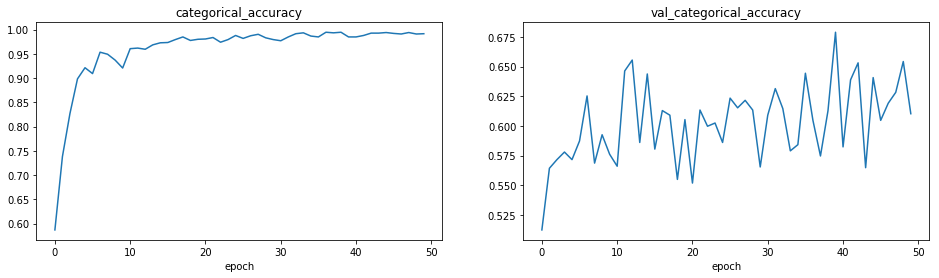

In [25]:
accuracy = list(history.history.get('categorical_accuracy'))
val_accuracy = list(history.history.get('val_categorical_accuracy'))

fig = plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
plt.title('categorical_accuracy')
plt.xlabel('epoch')
plt.plot(accuracy)

plt.subplot(1,2,2)
plt.title('val_categorical_accuracy')
plt.xlabel('epoch')
plt.plot(val_accuracy)

plt.show()

In [24]:
from keras.models import load_model
model = 'dicom_t1_axials_windowed_tumour_seg_noaug'
model_name = 'weights-improvement-40-0.68.hdf5'
             
model_dir = str(Path('methylation_models/{}/{}'.format(model, model_name)).absolute())

trained_methylation_model = load_model(model_dir)

In [27]:
##RESNET
methylation_pred = []

frame_lvl_conf = []
video_lvl_conf = []

frame_lvl_methylation_preds = []
ground_truth = []

methylation_status = ['True', 'False']

idx = 0

for index, row in val_set.iterrows():
    print('predicting on sequence : {}'.format(row['modality_path']))
    mri_vid = []
    for brain_slice in os.listdir(row['modality_path']):
        if str(brain_slice) in row['frames_with_tumour']:
            dcm = pydicom.dcmread(os.path.join(row['modality_path'],brain_slice))
            try:
                img = dcm.pixel_array*dcm.RescaleSlope+dcm.RescaleIntercept
            except:
                img = dcm.pixel_array                    
            if (np.mean(img)<20) & (np.std(img)<20):
                pass
            else:
                img = cv2.resize(img,(128,128))
                img = img/np.std(img)                
#                 img = (img - np.mean(img))/np.std(img)
                mri_vid.append(img.reshape(img.shape + (1,)))                
    mri_vid = np.array(mri_vid)
    preds = trained_methylation_model.predict(mri_vid)                 
    frame_lvl_max_pred = []                   
    frame_lvl_methylation_pred = []
    for frame_lvl_preds in preds:
        frame_lvl_max_pred.append(max(frame_lvl_preds))
        frame_lvl_methylation_pred.append(methylation_status[np.where(frame_lvl_preds==max(frame_lvl_preds))[0][0]])  

    frame_lvl_conf.append(frame_lvl_max_pred)
    frame_lvl_methylation_preds.append(frame_lvl_methylation_pred)

    ground_truth.append(row['methylation_status'])
    methylation_pred.append(Counter(frame_lvl_methylation_pred).most_common(1)[0][0])
#     if 'True' in frame_lvl_methylation_pred:
#         methylation_pred.append('True')
#     else:
#         methylation_pred.append('False')
    video_lvl_conf.append(Counter(frame_lvl_methylation_pred).most_common(1)[0][1]/len(frame_lvl_methylation_pred))
    idx +=1
    if idx%100==0:
        print('predicted on {} vids'.format(idx))

predicting on sequence : /external_drive/MRI_Deep_Learning/Methylation/data/TCGA-GBM/TCGA-02-0086/07-25-1999-MRI BRAIN WWO CONTR-49848/6-AX T1-94367


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pydicom/filereader.py:313: UserWarning: Expected explicit VR, but found implicit VR - using implicit VR for reading
  warnings.warn(message, UserWarning)


predicting on sequence : /external_drive/MRI_Deep_Learning/Methylation/data/TCGA-GBM/TCGA-02-0034/07-27-1997-MRI BRAIN WWO CONTRAMR-39956/12-AX T1-46175
predicting on sequence : /external_drive/MRI_Deep_Learning/Methylation/data/TCGA-GBM/TCGA-14-1794/04-11-1998-MRI BRAIN WWO CONT-42545/701-BRAIN      T1 AX PRE-53019
predicting on sequence : /external_drive/MRI_Deep_Learning/Methylation/data/TCGA-GBM/TCGA-19-5951/09-14-2003-NR MRI BRAIN WWO-33278/6-TIR T1 AX-11679
predicting on sequence : /external_drive/MRI_Deep_Learning/Methylation/data/TCGA-GBM/TCGA-12-1598/08-23-1999-MRI BRAIN-61414/5-T1AX-03736
predicting on sequence : /external_drive/MRI_Deep_Learning/Methylation/data/TCGA-GBM/TCGA-06-0139/11-09-2004-53123/8-AX T1 pre gd-59524
predicting on sequence : /external_drive/MRI_Deep_Learning/Methylation/data/TCGA-GBM/TCGA-02-0011/02-01-1998-MRI BRAIN WWO CONTRAMR-31709/5-AX T1-75594
predicting on sequence : /external_drive/MRI_Deep_Learning/Methylation/data/TCGA-GBM/TCGA-06-0133/07-28-20

In [28]:
prediction_results = pd.DataFrame(columns=['methylation_pred','ground_truth','frame_lvl_conf','video_lvl_conf','max_probs','frame_lvl_methylation_preds'])

prediction_results['methylation_pred'] =  methylation_pred 
prediction_results['ground_truth'] =  ground_truth 

prediction_results['frame_lvl_conf'] =  frame_lvl_conf 
prediction_results['video_lvl_conf'] =  video_lvl_conf 

prediction_results['frame_lvl_methylation_preds'] =  frame_lvl_methylation_preds 


In [33]:
print('video level accuracy-->')
len(np.where(prediction_results['methylation_pred'] == prediction_results['ground_truth'])[0])/len(prediction_results)

video level accuracy-->


0.8

In [34]:
print('video level true positive-->')
methylation_present_gt = prediction_results.loc[prediction_results['ground_truth']=='True']
len(np.where(methylation_present_gt['methylation_pred']=='True')[0])/len(methylation_present_gt)

video level true positive-->


0.75

In [35]:
print('video level true negative-->')
methylation_not_present_gt = prediction_results.loc[prediction_results['ground_truth']=='False']
len(np.where(methylation_not_present_gt['methylation_pred']=='False')[0])/len(methylation_not_present_gt)

video level true negative-->


0.8571428571428571